In [65]:
import hyppo
from hyppo.discrim._utils import _CheckInputs
from hyppo.independence import Dcorr
from dask.distributed import Client, progress
import dask.dataframe as ddf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.multivariate.manova import MANOVA

# Simulation Dependencies

In [66]:
from onesample import *
from simhelper import *
from onesample_sims import *

# No Effect

In [24]:
X, y, z = noeff_onesample(50, 2, 2, 2)

w, b, ratio = statistic(X, y, z)
dcor = dcorr_statistic(X, z)
manova = manova_statistic(X, y, z)
print("Within: {:3f}".format(w))
print("Between: {:3f}".format(b))
print("Ratio: {:3f}".format(ratio))
print("Dcor: {:3f}".format(dcor))
print("Manova: {:3f}".format(manova))

Within: 0.857740
Between: 0.860374
Ratio: 1.003070
Dcor: -0.017468
Manova: 0.995050


<AxesSubplot:xlabel='x1', ylabel='x2'>

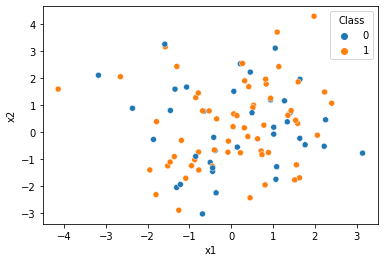

In [25]:
Xdat = pd.DataFrame({"x1": X[:,0],  "x2": X[:, 1], "Class": z, "individual": y})
sns.scatterplot(x="x1", y="x2", data=Xdat, hue="Class")

# Effect

In [63]:
X, y, z = gaussian_onesample(50, 2, 2, 2, effect_size=.75)

w, b, ratio = statistic(X, y, z)
dcor = dcorr_statistic(X, z)
manova = manova_statistic(X, y, z)
print("Within: {:3f}".format(w))
print("Between: {:3f}".format(b))
print("Ratio: {:3f}".format(ratio))
print("Dcor: {:3f}".format(dcor))
print("Manova: {:3f}".format(manova))

Within: 0.831458
Between: 0.861000
Ratio: 1.035530
Dcor: 0.233215
Manova: 0.694017


<AxesSubplot:xlabel='x1', ylabel='x2'>

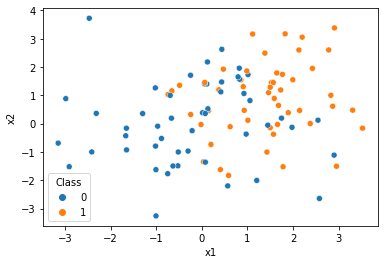

In [64]:
Xdat = pd.DataFrame({"x1": X[:,0],  "x2": X[:, 1], "Class": z, "individual": y})
sns.scatterplot(x="x1", y="x2", data=Xdat, hue="Class")

# Circle

In [37]:
X, y, z = ballcirc_onesample(50, 2, 2, 2, effect_size=0)

w, b, ratio = statistic(X, y, z)
dcor = dcorr_statistic(X, z)
manova = manova_statistic(X, y, z)
print("Within: {:3f}".format(w))
print("Between: {:3f}".format(b))
print("Ratio: {:3f}".format(ratio))
print("Dcor: {:3f}".format(dcor))
print("Manova: {:3f}".format(manova))

Within: 0.905142
Between: 0.959958
Ratio: 1.060561
Dcor: 0.104668
Manova: 0.952729


<AxesSubplot:xlabel='x1', ylabel='x2'>

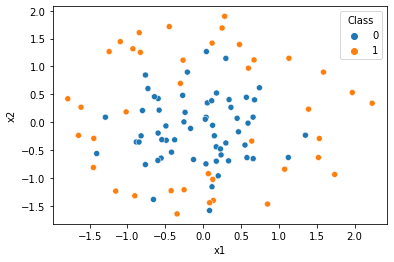

In [38]:
Xdat = pd.DataFrame({"x1": X[:,0],  "x2": X[:, 1], "Class": z, "individual": y})
sns.scatterplot(x="x1", y="x2", data=Xdat, hue="Class")

## One sample test

\begin{align*}
    H_0 : r = r_c\text{ against }H_A: r > r_c
\end{align*}
Where $r_c$ is the ratio $\frac{b_c}{w_c}$ if the class difference were $0$; that is, $\beta = 0_d$.

In [ ]:
ncores = 70
client = Client(threads_per_worker=1, n_workers=ncores)
client

In [ ]:
outer_reps = 100
pvalues = []
Nsubs = []
Nbreaks = 6
T = 3
ndim = 2
reps = 1000

def run_exp_ost(row):
    if row[0] == "Gaussian":
        X, y, z = gaussian_onesample(int(row[1]), T, ndim, 2, effect_size=.75)
    if row[0] == "No Effect":
        X, y, z = noeff_onesample(int(row[1]), T, ndim, 2)
    if row[0] == "Circle/Disc":
        X, y, z = ballcirc_onesample(int(row[1]), T, ndim, 2, effect_size=0)
    _, pvalue_cdiscr, _ = one_sample_test(X, y, z, reps=reps)
    pvalue_manova = one_sample_manova(X, y, z)
    _, pvalue_dcorr = one_sample_dcorr(X, z, reps=reps)
    return (row[0], row[1], row[2], pvalue_cdiscr, pvalue_manova, pvalue_dcorr)

exps = []
for exp_type in ["No Effect", "Gaussian", "Circle/Disc"]:
    for Nsub in np.floor(2**np.linspace(4, 7, num=Nbreaks)):
        for i in range(outer_reps):
            exps.append([exp_type, int(Nsub), i])

sim_exps = pd.DataFrame(exps, columns=["Simulation", "NSubs", "ID"])
print(sim_exps.head())
print(sim_exps.shape)

In [16]:
sim_exps = ddf.from_pandas(sim_exps, npartitions=int(ncores*1.5))
sim_results = sim_exps.apply(lambda x: run_exp_ost(x), axis=1, result_type="expand",
                            meta={0: object, 1: int, 2: int, 3: float, 4: float, 5: float})
sim_results

NameError: name 'sim_exps' is not defined

In [17]:
sim_results = sim_results.compute(scheduler="multiprocessing")
sim_results = sim_results.rename(columns={0: "Simulation", 1: "NSubs", 2: "index", 3: "pvalue_cdiscr",
                                          4: "pvalue_manova", 5: "pvalue_dcorr"})
sim_results.to_csv('./data/sims_onesample.csv')

NameError: name 'sim_results' is not defined

In [67]:
sim_results = pd.read_csv('./data/sims_onesample.csv')
long_results = pd.wide_to_long(sim_results, stubnames="pvalue", i=["Simulation", "NSubs", "index"],
                               j="Statistic", sep="_", suffix='\\w+')

In [68]:
alpha = .05
long_results["Outcome"] = long_results["pvalue"] < alpha
long_results_power = long_results.groupby(["Simulation", "NSubs", "Statistic"]).agg({"Outcome": np.mean}).reset_index()

In [69]:
long_results_power

,Simulation,NSubs,Statistic,Outcome
0,Circle/Disc,16,cdiscr,0.63
1,Circle/Disc,16,dcorr,0.88
2,Circle/Disc,16,manova,0.45
3,Circle/Disc,24,cdiscr,0.81
4,Circle/Disc,24,dcorr,0.93
5,Circle/Disc,24,manova,0.39
6,Circle/Disc,36,cdiscr,0.95
7,Circle/Disc,36,dcorr,1.00
8,Circle/Disc,36,manova,0.36
9,Circle/Disc,55,cdiscr,1.00


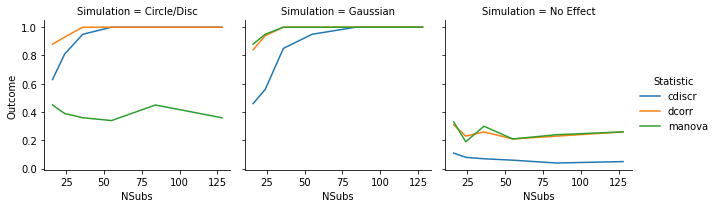

In [70]:
g = sns.FacetGrid(long_results_power, col="Simulation", hue="Statistic")
g.map(sns.lineplot, "NSubs", "Outcome")
g.add_legend();

# Asymptotic Consistency of $w$ and $b$

In [ ]:
outer_reps = 200
ws = []
bs = []
Nsubs = []
for Nsub in np.floor(2**np.linspace(4, 8, num=10)):
    print(int(Nsub))
    for i in range(outer_reps):
        X, y, z = simulate_gaussian_eff(int(Nsub), 2, 2, 2)
        w, b, ratio = statistic(X, y, z)
        ws.append(w)
        bs.append(b)
        Nsubs.append(Nsub)

In [ ]:
data = pd.DataFrame({"Within": ws, "Between": bs, "Number": Nsubs})
data["B/W"] = data["Between"]/data["Within"]
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.lineplot(data=data, x="Number", y="Within", ax=axs[0], ci="sd")
sns.lineplot(data=data, x="Number", y="Between", ax=axs[1], ci="sd")
sns.lineplot(data=data, x="Number", y="B/W", ax=axs[2], ci="sd")
axs[0].set_ylabel("Within Subject Discr")
axs[1].set_ylabel("Between Subject Discr")
axs[2].set_ylabel("B/W Ratio")
axs[0].set_xlabel("N")
axs[1].set_xlabel("N")
axs[2].set_xlabel("N")